In [1]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from importlib import reload
from shutil import rmtree
from itertools import islice

%matplotlib inline

# Task 1

In [2]:
from data_preparation import read_images, un_normalize
from model import cnn_model_fn, batch, similarity

## Loading Data

In [3]:
N_CLASSES = len(os.listdir('dataset/coarse/'))

coarse = read_images('dataset/coarse/')
fine = read_images('dataset/fine/')
real = read_images('dataset/real/')
train_idxs = ()
with open('dataset/real/training_split.txt') as f:
    train_idxs = set(int(x) for x in f.read().split(', '))
test_idxs = set(range(len(real))) - train_idxs
Sdb    = coarse
Strain = fine + [real[i] for i in train_idxs]
Stest  = [real[i] for i in test_idxs]

# Task 2

Creating the neural network

### Cache

In [4]:
import os

if __name__ == '__main__':
    CACHE_DIR = 'cache/'
    rmtree(CACHE_DIR)
    os.makedirs(CACHE_DIR)
    MODEL_PATH = os.path.join(CACHE_DIR,'cnn_model')
    INPUT_PATH = os.path.join(CACHE_DIR,'cnn_input')
    os.makedirs(MODEL_PATH)
    os.makedirs(INPUT_PATH)

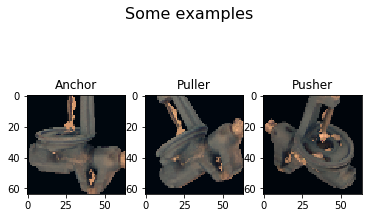

In [5]:
imgs = list(islice(map(un_normalize, batch(Sdb,Strain)()),3))
fig, ax = plt.subplots(1,3)
fig.suptitle('Some examples', fontsize=16)
ax[0].set_title('Anchor')
ax[0].imshow(imgs[0])
ax[1].set_title('Puller')
ax[1].imshow(imgs[1])
ax[2].set_title('Pusher')
ax[2].imshow(imgs[2]);

Define Model

In [6]:
cnn_descriptor = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir=MODEL_PATH)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cache/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb36563fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
# train input
def gen_train_input_fn(Sdb,Strain, batch_size):
    #Sdb    = features['Sdb']
    #Strain = features['Strain']
    #dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(batch(Sdb,Strain,batch_size)))
    assert(batch_size % 3 == 0)
    def inner():
        #b = batch(Sdb,Strain,batch_size)
        #dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(b))
        dataset = tf.data.Dataset.from_generator(
            batch(Sdb,Strain),
            tf.float32,
            tf.TensorShape([64, 64, 3])
        )
        return dataset.batch(batch_size)
    return inner

In [ ]:
train_input_fn = gen_train_input_fn(Sdb,Strain,300)
for x in range(10,30,10):
    cnn_descriptor.train(
        input_fn=train_input_fn,
        max_steps=x)

INFO:tensorflow:Calling model_fn.
(?, 16)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into cache/cnn_model/model.ckpt.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
Sdb_img = np.array([x.img for x in Sdb])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    np.array(Sdb_img),
    shuffle=False,
)

Sdb_descriptors = list(cnn_descriptor.predict(input_fn=eval_input_fn))

In [ ]:
Stest_img = np.array([x.img for x in Stest])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    Stest_img,
    shuffle=False,
)

Stest_descriptors = list(cnn_descriptor.predict(input_fn=eval_input_fn))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)
X, y = Sdb_descriptors, [x.cls for x in Sdb]
neigh.fit(X,y)

idxs = neigh.kneighbors(Stest_descriptors)[1]

hist = np.array([0,0,0,0])
N = len(Stest_descriptors)
for i in range(N):
    db = Sdb[idxs[i][0]]
    test = Stest[i]

    if db.cls != test.cls:
        continue

    theta = np.rad2deg(similarity(db.quat, test.quat))
    if theta < 10:
        hist[0] += 1
    if theta < 20:
        hist[1] += 1
    if theta < 40:
        hist[2] += 1
    hist[3] += 1

In [ ]:
100 * hist / N

In [ ]:
for i,d in enumerate(Sdb_descriptors):
    print(Sdb[i].cls,np.max(d))